### Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_validate, KFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV

import joblib

import shap

C:\Users\mcqui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

train_df.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


### EDA

### Feature Engineering

In [26]:
def feature_engineering(df):
    
    df = df.copy()
    df['perfect_attendance'] = np.where(df['class_attendance'] > 96, 1, 0)
    df['sleep_7'] = np.where(df['sleep_hours'] >= 7, 1, 0)
    df['sleep_rating'] = df['sleep_quality'] + "_" + df['sleep_7'].astype(str)

    df['facility_rating'] = pd.Categorical(df['facility_rating'],
                                           categories= ['low','medium','high'],
                                           ordered=True)

    return df

train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

In [22]:
train_df.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,perfect_attendance,sleep_7,sleep_rating
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3,1,0,average_0
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7,0,0,poor_0
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0,0,0,poor_0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9,0,1,average_1
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0,0,1,good_1


### Preprocessing

In [27]:
features = ['study_hours', 'class_attendance', 'perfect_attendance',
            'sleep_hours', 'sleep_quality', 'study_method',
            'facility_rating', 'sleep_rating']

X = train_df.loc[:,features]
y = train_df['exam_score']

numeric_features = ['study_hours', 'class_attendance', 'sleep_hours']
categorical_features = ['study_method', 'facility_rating', 'sleep_quality', 'sleep_rating']
binary_features = ['perfect_attendance']

PipeNum = Pipeline([
    ('scaler', StandardScaler())
])

PipeCat = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

PipeBinary = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', PipeNum, numeric_features),
    ('cat', PipeCat, categorical_features),
    ('binary', PipeBinary, binary_features),
], remainder='drop')

catboost_preprocessor = ColumnTransformer([
    ('num', PipeNum, numeric_features),
    ('cat', 'passthrough', categorical_features),
    ('binary', PipeBinary, binary_features),
], remainder='drop')

### Model Fitting

In [28]:
import warnings
warnings.filterwarnings('ignore')

from joblib import parallel_backend

cv_strategy = KFold(n_splits=5, shuffle=True, random_state=6323)

scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2',
    'mse': 'neg_mean_squared_error'
}

XGBoost

In [29]:
# XGBoost Model

param_distributions_xgb = {
    'regressor__n_estimators': randint(150,300), # Optimal: 234
    'regressor__learning_rate': uniform(.05, 0.25), # Optimal: 0.109
    'regressor__max_depth': randint(7,12), # Optimal: 8
    'regressor__gamma': uniform(1,3), # Optimal: 3.58
    'regressor__subsample': uniform(0.6, 0.9), # Optimal: 0.847
    'regressor__colsample_bytree': uniform(0.6, 0.9) # Optimal: 0.795
}

print("\nTuning XGBoost with RandomizedSearchCV...")
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        random_state=3554,
        tree_method='hist',
        objective='reg:squarederror',
        n_jobs=-1,
    ))
])

xgb_grid = RandomizedSearchCV(
    xgb_pipeline, 
    param_distributions=param_distributions_xgb,
    n_iter=30,  
    cv=cv_strategy, 
    scoring=scoring,
    refit='rmse', 
    n_jobs=1,  
    verbose=2,
    return_train_score=True,
    random_state=2664
)

print(f"Testing {xgb_grid.n_iter} random parameter combinations...")

with parallel_backend('threading'):
    xgb_grid.fit(X, y)

print("\n" + "="*80)
print("RANDOMIZED SEARCH RESULTS:")
print("="*80)
print(f"Best parameters: {xgb_grid.best_params_}")
print(f"Best RMSE: {-xgb_grid.best_score_:.3f}")

# Get all metrics for best model
best_idx = xgb_grid.best_index_
results = xgb_grid.cv_results_

print("\n" + "="*80)
print("XGB MODEL PERFORMANCE:")
print("="*80)
print(f"RMSE: {-results['mean_test_rmse'][best_idx]:.3f} (+/- {results['std_test_rmse'][best_idx]:.3f})")
print(f"MAE:  {-results['mean_test_mae'][best_idx]:.3f} (+/- {results['std_test_mae'][best_idx]:.3f})")
print(f"R²:   {results['mean_test_r2'][best_idx]:.3f} (+/- {results['std_test_r2'][best_idx]:.3f})")

results_df = pd.DataFrame({
    'params': results['params'],
    'mean_test_rmse': -results['mean_test_rmse'],
    'std_test_rmse': results['std_test_rmse'],
    'mean_test_r2': results['mean_test_r2'],
    'rank': results['rank_test_rmse']
}).sort_values('mean_test_rmse')

print("\n" + "="*80)
print("TOP 10 XGB PARAMETER COMBINATIONS:")
print("="*80)
print(results_df.head(10).to_string(index=False))

best_model_xgb = xgb_grid.best_estimator_


Tuning XGBoost with RandomizedSearchCV...
Testing 30 random parameter combinations...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END regressor__colsample_bytree=1.4007407120061652, regressor__gamma=2.4600013822896782, regressor__learning_rate=0.18424156659505897, regressor__max_depth=9, regressor__n_estimators=281, regressor__subsample=0.6038449644514132; total time=   0.6s
[CV] END regressor__colsample_bytree=1.4007407120061652, regressor__gamma=2.4600013822896782, regressor__learning_rate=0.18424156659505897, regressor__max_depth=9, regressor__n_estimators=281, regressor__subsample=0.6038449644514132; total time=   0.6s
[CV] END regressor__colsample_bytree=1.4007407120061652, regressor__gamma=2.4600013822896782, regressor__learning_rate=0.18424156659505897, regressor__max_depth=9, regressor__n_estimators=281, regressor__subsample=0.6038449644514132; total time=   0.6s
[CV] END regressor__colsample_bytree=1.4007407120061652, regressor__gamma=2.4600013822896782

LightGBM

In [ ]:
# LightGBM Model

param_distributions_lgbm = {
    'regressor__n_estimators': randint(150,300), # Optimal: 268
    'regressor__learning_rate': uniform(.01, 0.20), # Optimal: 0.203
    'regressor__max_depth': randint(3,12), # Optimal: 10
    'regressor__subsample': uniform(0.6, 0.9), # Optimal: 0.607
    'regressor__colsample_bytree': uniform(0.6, 0.9) # Optimal: 0.624 
}

print("\nTuning LightGBM with RandomizedSearchCV...")
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(
        random_state=6333,
        metric='rmse',
        objective='regression',
        n_jobs=-1,
    ))
])

lgbm_grid = RandomizedSearchCV(
    lgbm_pipeline, 
    param_distributions=param_distributions_lgbm,
    n_iter=30,
    cv=cv_strategy, 
    scoring=scoring,
    refit='rmse', 
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    random_state=5331
)

print(f"Testing {lgbm_grid.n_iter} random parameter combinations...")

with parallel_backend('threading'):
    lgbm_grid.fit(X, y)

print("\n" + "="*80)
print("RANDOMIZED SEARCH RESULTS:")
print("="*80)
print(f"Best parameters: {lgbm_grid.best_params_}")
print(f"Best RMSE: {-lgbm_grid.best_score_:.3f}")

# Get all metrics for best model
best_idx = lgbm_grid.best_index_
results = lgbm_grid.cv_results_

print("\n" + "="*80)
print("LGBM MODEL PERFORMANCE:")
print("="*80)
print(f"RMSE: {-results['mean_test_rmse'][best_idx]:.3f} (+/- {results['std_test_rmse'][best_idx]:.3f})")
print(f"MAE:  {-results['mean_test_mae'][best_idx]:.3f} (+/- {results['std_test_mae'][best_idx]:.3f})")
print(f"R²:   {results['mean_test_r2'][best_idx]:.3f} (+/- {results['std_test_r2'][best_idx]:.3f})")

results_df = pd.DataFrame({
    'params': results['params'],
    'mean_test_rmse': -results['mean_test_rmse'],
    'std_test_rmse': results['std_test_rmse'],
    'mean_test_r2': results['mean_test_r2'],
    'rank': results['rank_test_rmse']
}).sort_values('mean_test_rmse')

print("\n" + "="*80)
print("TOP 10 XGB PARAMETER COMBINATIONS:")
print("="*80)
print(results_df.head(10).to_string(index=False))

best_model_lgbm = lgbm_grid.best_estimator_


Tuning LightGBM with RandomizedSearchCV...
Testing 30 random parameter combinations...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END regressor__colsample_bytree=1.1729669034142165, regressor__learning_rate=0.12380750416089194, regressor__max_depth=9, regressor__n_estimators=161, regressor__subsample=0.8438402702588582; total time=   9.0s[CV] END regressor__colsample_bytree=1.4235038952491215, regressor__learning_rate=0.09616298767573352, regressor__max_depth=4, regressor__n_estimators=179, regressor__subsample=1.4427294576998146; total time=   9.2s

[CV] END regressor__colsample_bytree=1.30673122182757, regressor__learning_rate=0.20870181521029543, regressor__max_depth=5, regressor__n_estimators=176, regressor__subsample=1.2449868120168137; total time=   9.2s
[CV] END regressor__colsample_bytree=1.30673122182757, regressor__learning_rate=0.20870181521029543, regressor__max_depth=5, regressor__n_estimators=176, regressor__subsample=1.2449868120168137; total tim

Elastic Net

In [25]:
# Elastic Net Regression Model

param_grid_elastic = {
    'regressor__alpha': uniform(0.1, 10.0), # Optimal: 0.148
    'regressor__l1_ratio': uniform(0.1, 0.9) # Optimal: 0.741
}

print("\nTuning Elastic Net Regression...")

elastic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(random_state=1652, max_iter=1000))
])

elastic_grid = RandomizedSearchCV(
    elastic_pipeline, 
    param_distributions=param_grid_elastic,
    n_iter=50,
    cv=cv_strategy, 
    scoring=scoring,
    refit='rmse', 
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    random_state=3114
)

print(f"Testing {elastic_grid.n_iter} random parameter combinations...")

with parallel_backend('threading'):
    elastic_grid.fit(X, y)

print("\n" + "="*80)
print("RANDOMIZED SEARCH RESULTS:")
print("="*80)
print(f"Best parameters: {elastic_grid.best_params_}")
print(f"Best RMSE: {-elastic_grid.best_score_:.3f}")

# Get all metrics for best model
best_idx = elastic_grid.best_index_
results = elastic_grid.cv_results_

print("\n" + "="*80)
print("Elastic Net Model Performance:")
print("="*80)
print(f"RMSE: {-results['mean_test_rmse'][best_idx]:.3f} (+/- {results['std_test_rmse'][best_idx]:.3f})")
print(f"MAE:  {-results['mean_test_mae'][best_idx]:.3f} (+/- {results['std_test_mae'][best_idx]:.3f})")
print(f"R²:   {results['mean_test_r2'][best_idx]:.3f} (+/- {results['std_test_r2'][best_idx]:.3f})")

# View top 10 parameter combinations
results_df = pd.DataFrame({
    'params': results['params'],
    'mean_test_rmse': -results['mean_test_rmse'],
    'std_test_rmse': results['std_test_rmse'],
    'mean_test_r2': results['mean_test_r2'],
    'rank': results['rank_test_rmse']
}).sort_values('mean_test_rmse')

print("\n" + "="*80)
print("TOP 10 ELASTIC NET PARAMETER COMBINATIONS:")
print("="*80)
print(results_df.head(10).to_string(index=False))

# Optional: Print the L1 ratio of the best model to understand the regularization mix
best_l1_ratio = elastic_grid.best_params_['regressor__l1_ratio']
print(f"\nBest L1 ratio: {best_l1_ratio:.3f}")
print(f"Regularization mix: {best_l1_ratio*100:.1f}% L1 (Lasso), {(1-best_l1_ratio)*100:.1f}% L2 (Ridge)")

best_model_elastic = elastic_grid.best_estimator_


Tuning Elastic Net Regression...
Testing 50 random parameter combinations...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END regressor__alpha=7.6696861009476285, regressor__l1_ratio=0.13645726754179666; total time=  22.9s
[CV] END regressor__alpha=5.09049211859641, regressor__l1_ratio=0.3625636605123911; total time=  23.2s
[CV] END regressor__alpha=4.2024288362636, regressor__l1_ratio=0.5473084421064884; total time=  24.3s
[CV] END regressor__alpha=5.09049211859641, regressor__l1_ratio=0.3625636605123911; total time=  22.7s
[CV] END regressor__alpha=4.2024288362636, regressor__l1_ratio=0.5473084421064884; total time=  23.7s
[CV] END regressor__alpha=4.2024288362636, regressor__l1_ratio=0.5473084421064884; total time=  26.5s
[CV] END regressor__alpha=5.9728626094835695, regressor__l1_ratio=0.9848559262864519; total time=  23.9s
[CV] END regressor__alpha=5.09049211859641, regressor__l1_ratio=0.3625636605123911; total time=  24.4s
[CV] END regressor__alpha=7.669686

CatBoost

In [ ]:
# CatBoost Regression Model

param_grid_catboost = {
    'regressor__iterations': randint(50, 150), # Optimal: 136
    'regressor__learning_rate': uniform(0.01, 0.3), # Optimal: 0.203
    'regressor__depth': randint(3, 6), # Optimal: 5
    'regressor__l2_leaf_reg': uniform(1, 50) # Optimal: 9.498
}

print("\nTuning CatBoost Regression...")


X[categorical_features] = X[categorical_features].astype(str)
num_count = len(numeric_features)
cat_count = len(categorical_features)
cat_indices = list(range(num_count, num_count + cat_count))

catboost_pipeline = Pipeline([
    ('preprocessor', catboost_preprocessor),
    ('regressor', CatBoostRegressor(random_state=1652, 
                                    cat_features=cat_indices, 
                                    boosting_type='Plain',
                                    thread_count=4,
                                    verbose=False
                                    ))
])

cv_catboost = KFold(n_splits=3, shuffle=True, random_state=4512)

catboost_grid = RandomizedSearchCV(
    catboost_pipeline,
    param_distributions=param_grid_catboost,
    n_iter=30,
    cv=cv_catboost, 
    scoring=scoring,
    refit='rmse', 
    n_jobs=1,
    verbose=2,
    return_train_score=True,
    random_state=3114,
)

print(f"Testing {catboost_grid.n_iter} random parameter combinations...")

catboost_grid.fit(X, y)

print("\n" + "="*80)
print("RANDOMIZED SEARCH RESULTS:")
print("="*80)
print(f"Best parameters: {catboost_grid.best_params_}")
print(f"Best RMSE: {-catboost_grid.best_score_:.3f}")

# Get all metrics for best model
best_idx = catboost_grid.best_index_
results = catboost_grid.cv_results_

print("\n" + "="*80)
print("CatBoost Model Performance:")
print("="*80)
print(f"RMSE: {-results['mean_test_rmse'][best_idx]:.3f} (+/- {results['std_test_rmse'][best_idx]:.3f})")
print(f"MAE:  {-results['mean_test_mae'][best_idx]:.3f} (+/- {results['std_test_mae'][best_idx]:.3f})")
print(f"R²:   {results['mean_test_r2'][best_idx]:.3f} (+/- {results['std_test_r2'][best_idx]:.3f})")

# View top 10 parameter combinations
results_df = pd.DataFrame({
    'params': results['params'],
    'mean_test_rmse': -results['mean_test_rmse'],
    'std_test_rmse': results['std_test_rmse'],
    'mean_test_r2': results['mean_test_r2'],
    'rank': results['rank_test_rmse']
}).sort_values('mean_test_rmse')

print("\n" + "="*80)
print("TOP 10 ELASTIC NET PARAMETER COMBINATIONS:")
print("="*80)
print(results_df.head(10).to_string(index=False))

best_model_catboost = catboost_grid.best_estimator_


Tuning CatBoost Regression...
Testing 30 random parameter combinations...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END regressor__depth=5, regressor__iterations=75, regressor__l2_leaf_reg=2.8612816024454695, regressor__learning_rate=0.014271084905806322; total time=   6.3s
[CV] END regressor__depth=5, regressor__iterations=75, regressor__l2_leaf_reg=2.8612816024454695, regressor__learning_rate=0.014271084905806322; total time=   6.4s
[CV] END regressor__depth=5, regressor__iterations=75, regressor__l2_leaf_reg=2.8612816024454695, regressor__learning_rate=0.014271084905806322; total time=   6.3s
[CV] END regressor__depth=4, regressor__iterations=105, regressor__l2_leaf_reg=25.850469005916025, regressor__learning_rate=0.1597147635578923; total time=   7.1s
[CV] END regressor__depth=4, regressor__iterations=105, regressor__l2_leaf_reg=25.850469005916025, regressor__learning_rate=0.1597147635578923; total time=   7.3s
[CV] END regressor__depth=4, regressor__iterat

MLP Neural Network

In [15]:
# MLP NN Regression Model

param_grid_mlp = {
    'regressor__hidden_layer_sizes': [(100,), (100, 50), (50, 50, 50)], # Optimal: (100,)
    'regressor__learning_rate_init': loguniform(1e-4, 1e-1), # Optimal: 0.008
    'regressor__alpha': loguniform(1e-5, 1e-1), # Optimal: 0.021
    'regressor__max_iter': randint(50, 200), # Optimal: 182
}

print("\nTuning MLP Regression...")

mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(random_state=1652,
                               activation='relu',
                               early_stopping=True))
])

mlp_grid = HalvingRandomSearchCV(
    mlp_pipeline, 
    param_distributions=param_grid_mlp,
    factor=3,
    n_candidates=50,
    min_resources=1000,
    max_resources=630000,
    cv=cv_strategy, 
    scoring='neg_root_mean_squared_error',
    refit='rmse', 
    n_jobs=1,
    verbose=2,
    return_train_score=True,
    random_state=3114
)

print(f"Testing {mlp_grid.n_candidates} random parameter combinations...")

# with parallel_backend('threading'):
mlp_grid.fit(X, y)

print("\n" + "="*80)
print("RANDOMIZED SEARCH RESULTS:")
print("="*80)
print(f"Best parameters: {mlp_grid.best_params_}")
print(f"Best RMSE: {-mlp_grid.best_score_:.3f}")

# Get all metrics for best model
best_idx = mlp_grid.best_index_
results = mlp_grid.cv_results_

print("\n" + "="*80)
print("MLP Model Performance:")
print("="*80)
# print(f"RMSE: {-results['mean_test_rmse'][best_idx]:.3f} (+/- {results['std_test_rmse'][best_idx]:.3f})")
# print(f"MAE:  {-results['mean_test_mae'][best_idx]:.3f} (+/- {results['std_test_mae'][best_idx]:.3f})")
# print(f"R²:   {results['mean_test_r2'][best_idx]:.3f} (+/- {results['std_test_r2'][best_idx]:.3f})")

# View top 10 parameter combinations
results_df = pd.DataFrame({
    'params': results['params'],
    'mean_test_rmse': -results['mean_test_rmse'],
    'std_test_rmse': results['std_test_rmse'],
    'mean_test_r2': results['mean_test_r2'],
    'rank': results['rank_test_rmse']
}).sort_values('mean_test_rmse')

print("\n" + "="*80)
print("TOP 10 MLP PARAMETER COMBINATIONS:")
print("="*80)
print(results_df.head(10).to_string(index=False))

best_model_mlp = mlp_grid.best_estimator_


Tuning MLP Regression...
Testing 50 random parameter combinations...
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 6
min_resources_: 1000
max_resources_: 630000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 50
n_resources: 1000
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END regressor__alpha=0.002234318306204754, regressor__hidden_layer_sizes=(100, 50), regressor__learning_rate_init=0.00012932333513211383, regressor__max_iter=155; total time=   0.5s
[CV] END regressor__alpha=0.002234318306204754, regressor__hidden_layer_sizes=(100, 50), regressor__learning_rate_init=0.00012932333513211383, regressor__max_iter=155; total time=   0.5s
[CV] END regressor__alpha=0.002234318306204754, regressor__hidden_layer_sizes=(100, 50), regressor__learning_rate_init=0.00012932333513211383, regressor__max_iter=155; total time=   0.5s
[CV] END regressor__alpha=0.002234318306204754, regressor__hidden_layer_sizes=(100, 50), regressor__lea

KeyError: 'mean_test_rmse'

KNN Model (Getting Dropped)

In [ ]:
# KNN Regression Model

param_grid_KNN = {
    'regressor__n_neighbors': randint(5, 60), # Optimal: 56 (Anything between 30 and 60 seems fine here)
    'regressor__weights': ['distance'],
    'regressor__p': [1, 2],            # Optimal: 2
    'regressor__leaf_size': [30, 50, 100] # Optimal: 100
}

print("\nTuning KNN Regression...")

knn_pipeline = Pipeline([('preprocessor', preprocessor),
                         ('regressor', KNeighborsRegressor())])

knn_grid = RandomizedSearchCV(
    knn_pipeline, 
    param_distributions = param_grid_KNN,
    n_iter=20,
    cv=cv_strategy, 
    scoring=scoring,
    refit='rmse', 
    n_jobs=1,
    verbose=2,
    return_train_score=True,
    random_state=3651
)

print(f"Testing {knn_grid.n_iter} random parameter combinations...")

with parallel_backend('threading'):
    X_sample = X.sample(frac=0.15, random_state=6656)
    y_sample = y[X_sample.index]

    knn_grid.fit(X_sample, y_sample)

print("\n" + "="*80)
print("RANDOMIZED SEARCH RESULTS:")
print("="*80)
print(f"Best parameters: {knn_grid.best_params_}")
print(f"Best RMSE: {-knn_grid.best_score_:.3f}")

best_idx = knn_grid.best_index_
results = knn_grid.cv_results_

print("\n" + "="*80)
print("KNN MODEL PERFORMANCE:")
print("="*80)
print(f"RMSE: {-results['mean_test_rmse'][best_idx]:.3f} (+/- {results['std_test_rmse'][best_idx]:.3f})")
print(f"MAE:  {-results['mean_test_mae'][best_idx]:.3f} (+/- {results['std_test_mae'][best_idx]:.3f})")
print(f"R²:   {results['mean_test_r2'][best_idx]:.3f} (+/- {results['std_test_r2'][best_idx]:.3f})")

# View top 10 parameter combinations

results_df = pd.DataFrame({
    'params': results['params'],
    'mean_test_rmse': -results['mean_test_rmse'],
    'std_test_rmse': results['std_test_rmse'],
    'mean_test_r2': results['mean_test_r2'],
    'rank': results['rank_test_rmse']
}).sort_values('mean_test_rmse')

print("\n" + "="*80)
print("TOP 10 KNN PARAMETER COMBINATIONS:")
print("="*80)
print(results_df.head(10).to_string(index=False))

best_model_knn = knn_grid.best_estimator_


Tuning KNN Regression...
Testing 20 random parameter combinations...
This should take 5-15 minutes...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END regressor__leaf_size=30, regressor__n_neighbors=42, regressor__p=1, regressor__weights=distance; total time=   2.1s
[CV] END regressor__leaf_size=30, regressor__n_neighbors=42, regressor__p=1, regressor__weights=distance; total time=   2.9s
[CV] END regressor__leaf_size=30, regressor__n_neighbors=42, regressor__p=1, regressor__weights=distance; total time=   3.0s
[CV] END regressor__leaf_size=30, regressor__n_neighbors=42, regressor__p=1, regressor__weights=distance; total time=   3.1s
[CV] END regressor__leaf_size=30, regressor__n_neighbors=42, regressor__p=1, regressor__weights=distance; total time=   3.1s
[CV] END regressor__leaf_size=100, regressor__n_neighbors=27, regressor__p=1, regressor__weights=distance; total time=   3.1s
[CV] END regressor__leaf_size=100, regressor__n_neighbors=27, regressor__p=1, regres

Ensamble Model Pipeline

In [32]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

    # XGBoost with tuned hyperparameters

xgb_base = XGBRegressor(
    n_estimators=234, 
    learning_rate=0.109,
    max_depth=8,
    gamma=3.58,
    subsample=0.847,
    colsample_bytree=0.795,
    random_state=3554,
    tree_method='hist',
    objective='reg:squarederror',
    n_jobs=-1
)

xgb_mod = Pipeline([('preprocessor', preprocessor),
                    ('model', xgb_base)])

    # LightGBM with tuned hyperparameters

lgbm_base = LGBMRegressor(
    n_estimators=268,
    learning_rate=0.203,
    max_depth=10,
    subsample=0.607,
    colsample_bytree=0.624,
    random_state=6333,
    metric='rmse',
    objective='regression',
    n_jobs=-1
)

lgbm_mod = Pipeline([('preprocessor', preprocessor), 
                     ('model', lgbm_base)])

    # Elastic Net Regression with tuned hyperparameters

elastic_net_base = ElasticNet(alpha = 0.148,
                              l1_ratio = 0.741,
                              max_iter = 1000,
                              random_state = 1652)

elastic_net_mod = Pipeline([('preprocessor', preprocessor), 
                            ('model', elastic_net_base)])

    # CatBoost Regressor with tuned hyperparameters

X[categorical_features] = X[categorical_features].astype(str)
num_count = len(numeric_features)
cat_count = len(categorical_features)
cat_indices = list(range(num_count, num_count + cat_count))

catboost_base = CatBoostRegressor(
    iterations=136,
    learning_rate=0.203,
    depth=5,
    l2_leaf_reg=9.498,
    random_state=1652,
    cat_features=cat_indices,
    boosting_type='Plain',
    thread_count=4,
    verbose=False
)

catboost_mod = Pipeline([('preprocessor', catboost_preprocessor), 
                         ('model', catboost_base)])

    # MLP Regressor with tuned hyperparameters

mlp_base = MLPRegressor(
    hidden_layer_sizes=(100,),
    learning_rate_init=0.008,
    alpha=0.021,
    max_iter=182,
    random_state=1652,
    activation='relu',
    early_stopping=True
)

mlp_mod = Pipeline([('preprocessor', preprocessor), 
                    ('model', mlp_base)])

    # Stacking Ensemble

estimators = [
    ('xgb', xgb_mod),
    ('lgbm', lgbm_mod),
    ('elastic_net', elastic_net_mod),
    ('catboost', catboost_mod),
    ('mlp', mlp_mod),
]

stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1),
    cv=cv_strategy,
    n_jobs=1
)

Model Fits

In [ ]:
print("Fitting Stacking Regressor (includes all base models)...")
stack_model.fit(X, y)
joblib.dump(stack_model, "StackedRegressor_model.joblib")


fitted_base_models = stack_model.estimators_
base_model_names = [name for name, _ in stack_model.estimators]

for name, fitted_model in zip(base_model_names, fitted_base_models):
    print(f"Saving fitted {name}...")
    joblib.dump(fitted_model, f"{name}_model.joblib")

print("\nAll models saved!")
print(f"Base models: {base_model_names}")
print(f"Final estimator: {type(stack_model.final_estimator_).__name__}")

Fitting Stacking Regressor (includes all base models)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 592
[LightGBM] [Info] Number of data points in the train set: 630000, number of used features: 17
[LightGBM] [Info] Start training from score 62.506672
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 17
[LightGBM] [Info] Start training from score 62.489498
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005258 seconds.
You can set `force_row_wi

SHAP Values

In [34]:
stacking_model = joblib.load('StackedRegressor_model.joblib')

if hasattr(stacking_model, 'named_steps'):
    stacking_regressor = stacking_model.named_steps['regressor']
    preprocessor = stacking_model.named_steps['preprocessor']
    X_processed = preprocessor.transform(X)
else:
    stacking_regressor = stacking_model
    X_processed = X

print("Analyzing Stacking Regressor...")

base_model_names = [name for name, _ in stacking_regressor.estimators]
print(f"Base models: {base_model_names}")
print(f"Final estimator: {type(stacking_regressor.final_estimator_).__name__}")

meta_features = stacking_regressor.transform(X_processed)

print(f"\nMeta-features shape: {meta_features.shape}")

explainer = shap.LinearExplainer(stacking_regressor.final_estimator_, meta_features)
shap_values = explainer.shap_values(meta_features)

meta_importance = pd.DataFrame({
    'base_model': base_model_names,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0),
    'ridge_coefficient': stacking_regressor.final_estimator_.coef_
}).sort_values('mean_abs_shap', ascending=False)

print("\nBase Model Contributions:")
print(meta_importance.to_string(index=False))

Analyzing Stacking Regressor...
Base models: ['xgb', 'lgbm', 'elastic_net', 'catboost', 'mlp']
Final estimator: Ridge

Meta-features shape: (630000, 5)

Base Model Contributions:
 base_model  mean_abs_shap  ridge_coefficient
        xgb       7.233361           0.513428
       lgbm       6.811106           0.483865
   catboost       0.849005           0.060421
        mlp       0.632237          -0.044713
elastic_net       0.172252          -0.013167


Stacked Model Base Model Importance Plot


META-MODEL ANALYSIS: How base models are combined


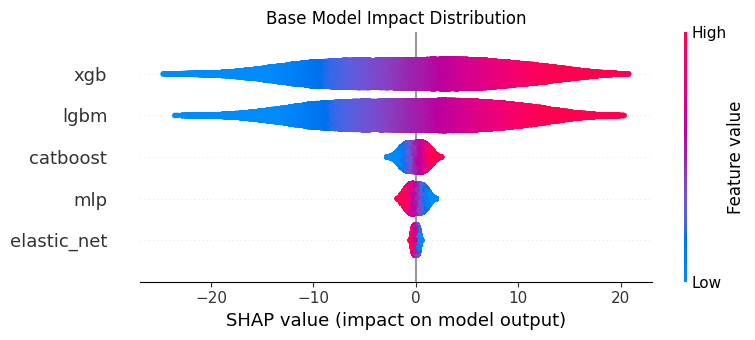

In [35]:
print("\n" + "="*80)
print("META-MODEL ANALYSIS: How base models are combined")
print("="*80)

shap.summary_plot(shap_values, meta_features, 
                 feature_names=base_model_names,
                 show=False)
plt.title('Base Model Impact Distribution')
plt.tight_layout()
plt.show()

Stacked Model Base Model Waterfall Plot


Generating waterfall plot for first prediction...


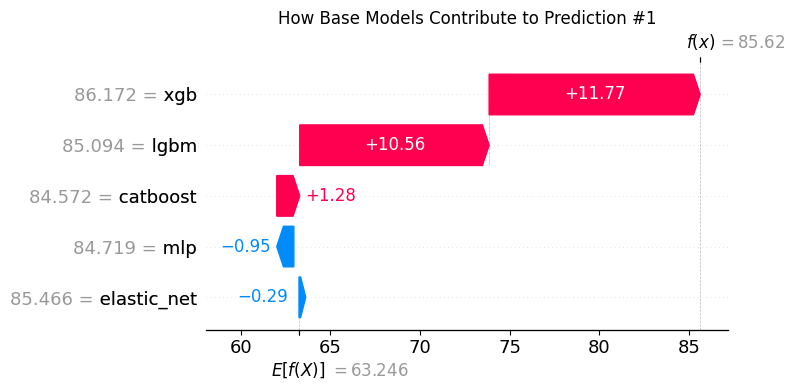

In [36]:
# Waterfall plot for a single prediction
print("\nGenerating waterfall plot for first prediction...")
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[0], 
        base_values=explainer.expected_value,
        data=meta_features[0],
        feature_names=base_model_names
    ), show = False)

plt.title('How Base Models Contribute to Prediction #1')
plt.tight_layout()
plt.show()

LGBM Shap Value Analysis

In [37]:
lgbm_pipeline = joblib.load('lgbm_model.joblib')
lgbm_model = lgbm_pipeline.named_steps['model']

explainer = shap.TreeExplainer(lgbm_model)
preprocessor = lgbm_pipeline.named_steps['preprocessor']

print("Fitting Shap")

shap_indices = np.random.choice(len(X), size=10000, replace=False)
X_sample = X.iloc[shap_indices]
X_processed = preprocessor.transform(X_sample)

lgbm_shap_values = explainer(X_processed)

feature_names = preprocessor.get_feature_names_out()
lgbm_shap_values.feature_names = feature_names

print("SHAP values calculated!")

Fitting Shap
SHAP values calculated!



Creating beeswarm plot...


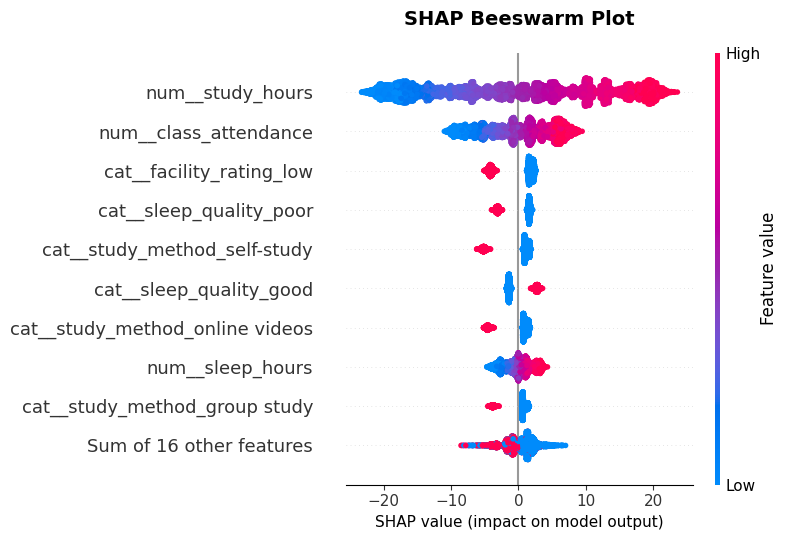

In [18]:
print("\nCreating beeswarm plot...")
# plt.figure(figsize=(10, 6))
shap.plots.beeswarm(lgbm_shap_values, show=False)
plt.title("SHAP Beeswarm Plot", 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("SHAP value (impact on model output)", fontsize=11)
plt.tight_layout()
plt.show()

In [38]:
shap_importance = np.abs(lgbm_shap_values.values).mean(axis=0)

feature_importance_df = pd.DataFrame({
    'feature': lgbm_shap_values.feature_names,
    'importance': shap_importance
}).sort_values('importance', ascending=False)

print(feature_importance_df)

                            feature  importance
0                  num__study_hours   11.769285
1             num__class_attendance    4.540695
7          cat__facility_rating_low    2.720495
6      cat__study_method_self-study    2.002399
5   cat__study_method_online videos    1.782070
9           cat__sleep_quality_good    1.599910
3     cat__study_method_group study    1.443363
10          cat__sleep_quality_poor    1.414784
2                  num__sleep_hours    1.298068
8       cat__facility_rating_medium    1.199648
4           cat__study_method_mixed    0.948457
13         cat__sleep_rating_good_1    0.532691
14         cat__sleep_rating_poor_0    0.482789
11      cat__sleep_rating_average_1    0.424918
16     binary__perfect_attendance_1    0.326877
15         cat__sleep_rating_poor_1    0.056604
12         cat__sleep_rating_good_0    0.055313


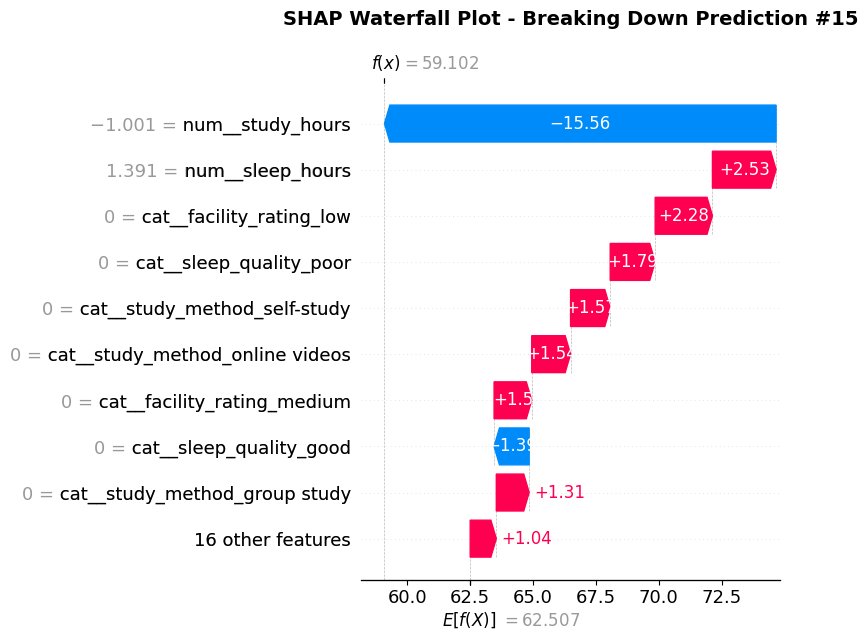


WATERFALL PLOT INTERPRETATION:
- Base value (E[f(X)]): 62.507 - The average prediction across all training data
- Final prediction (f(x)): 59.102
- Difference explained by features: -3.405



In [27]:
instance_idx = 15

plt.figure(figsize=(10, 6))
shap.plots.waterfall(lgbm_shap_values[instance_idx], show=False)
plt.title(f"SHAP Waterfall Plot - Breaking Down Prediction #{instance_idx}", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print actual values for context
actual_prediction = lgbm_model.predict(X_processed[[instance_idx]])[0]
base_value = lgbm_shap_values.base_values[instance_idx]

print(f"""
WATERFALL PLOT INTERPRETATION:
- Base value (E[f(X)]): {base_value:.3f} - The average prediction across all training data
- Final prediction (f(x)): {actual_prediction:.3f}
- Difference explained by features: {actual_prediction - base_value:.3f}
""")

<Figure size 1000x600 with 0 Axes>

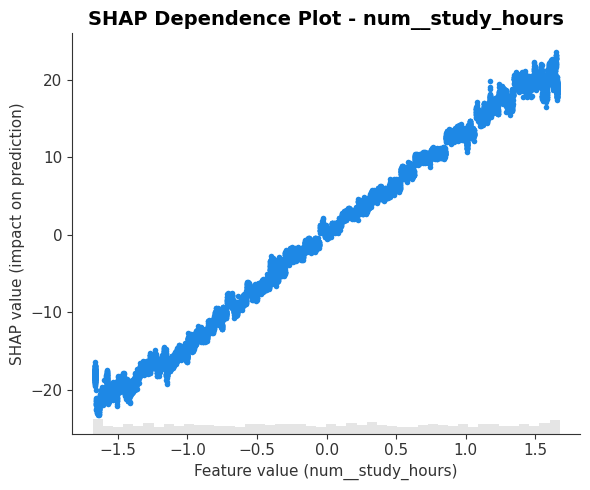

In [28]:
feature = "num__study_hours"

plt.figure(figsize=(10, 6))
shap.plots.scatter(lgbm_shap_values[:, feature], show=False)
plt.title(f"SHAP Dependence Plot - {feature}", fontsize=14, fontweight='bold')
plt.xlabel(f"Feature value ({feature})", fontsize=11)
plt.ylabel("SHAP value (impact on prediction)", fontsize=11)
plt.tight_layout()
plt.show()

XGB Shap Value Analysis

In [15]:
xgb_pipeline = joblib.load('xgb_model.joblib')
xgb_model = xgb_pipeline.named_steps['model']

explainer = shap.TreeExplainer(xgb_model)
preprocessor = xgb_pipeline.named_steps['prep'] # Switch to 'preprocessor' when run again

print("Fitting Shap")

# shap_indices = np.random.choice(len(X), size=10000, replace=False)
X_sample = X.iloc[shap_indices]
X_processed = preprocessor.transform(X_sample)

xgb_shap_values = explainer(X_processed)

feature_names = preprocessor.get_feature_names_out()
xgb_shap_values.feature_names = feature_names

print("SHAP values calculated!")

Fitting Shap
SHAP values calculated!



Creating beeswarm plot...


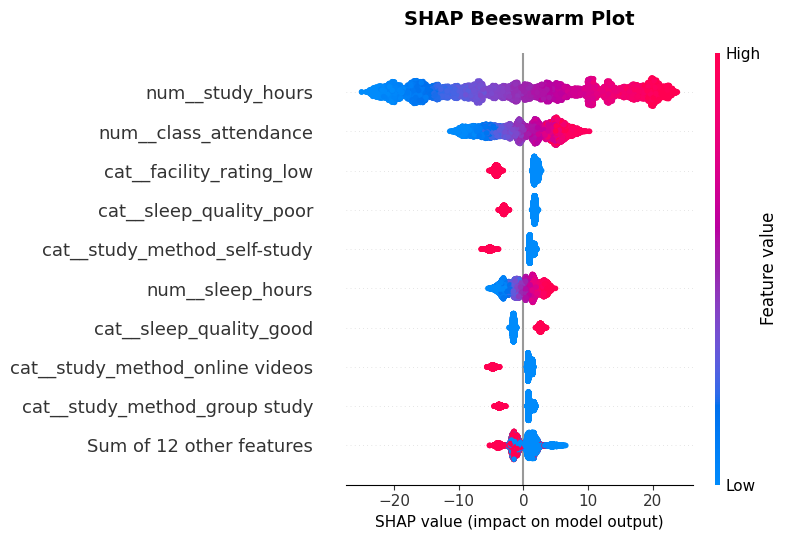

In [16]:
print("\nCreating beeswarm plot...")
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(xgb_shap_values, show=False)
plt.title("SHAP Beeswarm Plot", 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel("SHAP value (impact on model output)", fontsize=11)
plt.tight_layout()
plt.show()

In [ ]:
instance_idx = 15

plt.figure(figsize=(10, 6))
shap.plots.waterfall(xgb_shap_values[instance_idx], show=False)
plt.title(f"SHAP Waterfall Plot - Breaking Down Prediction #{instance_idx}", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print actual values for context
actual_prediction = xgb_model.predict(X_processed[[instance_idx]])[0]
base_value = xgb_shap_values.base_values[instance_idx]

print(f"""
WATERFALL PLOT INTERPRETATION:
- Base value (E[f(X)]): {base_value:.3f} - The average prediction across all training data
- Final prediction (f(x)): {actual_prediction:.3f}
- Difference explained by features: {actual_prediction - base_value:.3f}
""")

In [ ]:
feature = "cat__study_method_self-study"

plt.figure(figsize=(10, 6))
shap.plots.scatter(xgb_shap_values[:, feature], show=False)
plt.title(f"SHAP Dependence Plot - {feature}", fontsize=14, fontweight='bold')
plt.xlabel(f"Feature value ({feature})", fontsize=11)
plt.ylabel("SHAP value (impact on prediction)", fontsize=11)
plt.tight_layout()
plt.show()

Side by Side

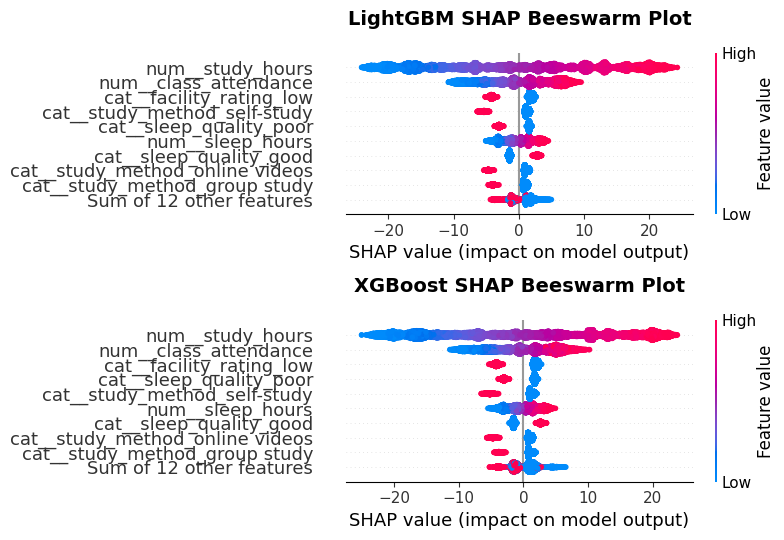

In [20]:
# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))

# Left plot - LightGBM
plt.sca(ax1)  # Set current axis
shap.plots.beeswarm(lgbm_shap_values, show=False)
ax1.set_title("LightGBM SHAP Beeswarm Plot", 
              fontsize=14, fontweight='bold', pad=20)

# Right plot - XGBoost
plt.sca(ax2)  # Set current axis
shap.plots.beeswarm(xgb_shap_values, show=False)
ax2.set_title("XGBoost SHAP Beeswarm Plot", 
              fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

### Predictions

In [39]:
X_test = test_df.loc[:,features]
y_pred = stack_model.predict(X_test)

submission = pd.DataFrame({
    'id': test_df['id'],
    'exam_score': y_pred
})

submission.to_csv('submission.csv', index=False)